In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## Data Cleaning

In [4]:
data= pd.read_excel('/content/drive/MyDrive/projetIA/Projet1/online_retail_II.xlsx', sheet_name='Year 2009-2010')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [20]:
df= data.copy()

#### Traitement de la colonne 'InvoiceNo'
* Suppression des individus avec un InvoiceNo qui n'est pas 6-Digits

In [21]:
df['Invoice']=df['Invoice'].astype('str')
df= df[df['Invoice'].str.match("^\\d{6}$")==True]

In [9]:
df.shape

(515252, 8)

#### Traitement de la colonne 'StockCode'

In [22]:
df['StockCode']=df['StockCode'].astype('str')
mask = (
    df['StockCode'].str.match('^\\d{5}$') |
    df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$') |
    df['StockCode'].str.match('^PADS$')
)

df = df[mask]

In [23]:
df.shape

(512796, 8)

In [14]:
515252-512796

2456

In [24]:
#Verifions al description du dataset
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,512796.000000,512796,512796.000000,406337.000000
mean,11.001279,2010-06-28 18:26:52.709732352,3.391447,15373.632992
min,-9600.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,1.000000,2010-03-21 13:27:00,1.250000,14004.000000
50%,3.000000,2010-07-06 14:25:00,2.100000,15326.000000
75%,10.000000,2010-10-15 14:50:00,4.210000,16814.000000
max,19152.000000,2010-12-09 20:01:00,1157.150000,18287.000000
std,104.352433,NaN,5.067864,1677.365907


* Le Price a une valeur mini qui est 0==> Ces individus doivent etre chercher et supprimer
* La Quantity a une valeur min qui negative. On doit fixer cela avec le Customer ID

In [25]:
df.dropna(subset=['Customer ID'], inplace=True)

In [26]:
df.shape

(406337, 8)

In [27]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.000000,406337,406337.000000,406337.000000
mean,13.619099,2010-07-01 10:11:06.543288320,2.991462,15373.632992
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,14004.000000
50%,5.000000,2010-07-09 15:48:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,97.000659,NaN,4.285876,1677.365907


* La quantite a une valeur min qui est 1 maintenant

In [28]:
df['Price'].min()

0.0

In [29]:
len(df[df['Price']==0])

28

In [30]:
df= df[df['Price']>0]

In [31]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.000000,406309,406309.000000,406309.000000
mean,13.617924,2010-07-01 10:14:25.869572352,2.991668,15373.722268
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,14006.000000
50%,5.000000,2010-07-09 15:48:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,96.998833,NaN,4.285951,1677.329470


In [34]:
len(df)

406309

* Dans le nettoyage on a eu a supprimer 22.67% de nos individus.
* Il nous reste tjrs: 406309 individus dans notre dataset. Oui cela peut nous permettre de faire des hypotheses statistiques et des predictions

## Feature Engineering

In [35]:
cleaned_data= df.copy()

In [36]:
# La colonne 'venteTotal'

cleaned_data['VenteTotal']= cleaned_data['Quantity']*cleaned_data['Price']
cleaned_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,VenteTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [37]:
# Une aggregation pour regrouper les donnes par Customer ID et en utilisant des nouvelles colonnes
aggregated_data= cleaned_data.groupby(by='Customer ID',as_index=False)\
                  .agg(
                      MonetaryValue=('VenteTotal','sum'),
                      Frequency=('Invoice','nunique'),
                      LastInvoiceDate=('InvoiceDate','max')
                  )
aggregated_data


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.0,169.36,2,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00
3,12349.0,2221.14,2,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00
...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00
4281,18284.0,411.68,1,2010-10-04 11:33:00
4282,18285.0,377.00,1,2010-02-17 10:24:00
4283,18286.0,1246.43,2,2010-08-20 11:57:00


In [38]:
max_invoice_date= cleaned_data['InvoiceDate'].max()
max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [39]:
aggregated_data['recency']= (max_invoice_date-aggregated_data['LastInvoiceDate']).dt.days
aggregated_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00,17
4281,18284.0,411.68,1,2010-10-04 11:33:00,66
4282,18285.0,377.00,1,2010-02-17 10:24:00,295
4283,18286.0,1246.43,2,2010-08-20 11:57:00,111


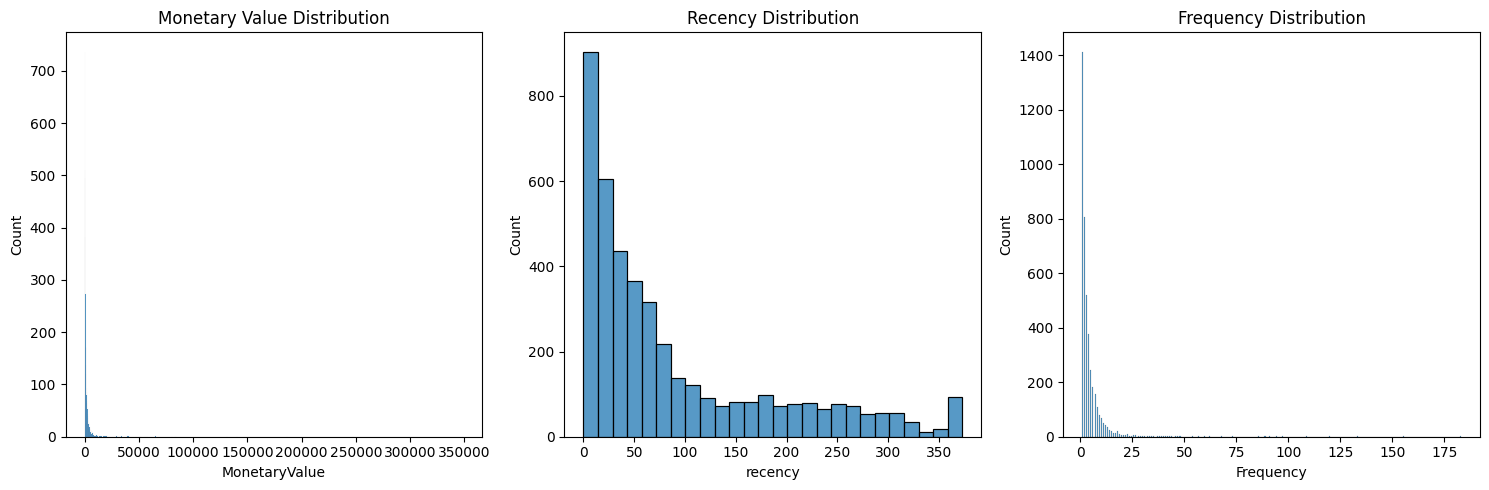

In [40]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot MonetaryValue
sns.histplot(aggregated_data['MonetaryValue'], ax=axes[0])
axes[0].set_title('Monetary Value Distribution')

# Plot recency
sns.histplot(aggregated_data['recency'], ax=axes[1])
axes[1].set_title('Recency Distribution')

# Plot Frequency
sns.histplot(aggregated_data['Frequency'], ax=axes[2])
axes[2].set_title('Frequency Distribution')

plt.tight_layout()
plt.show()


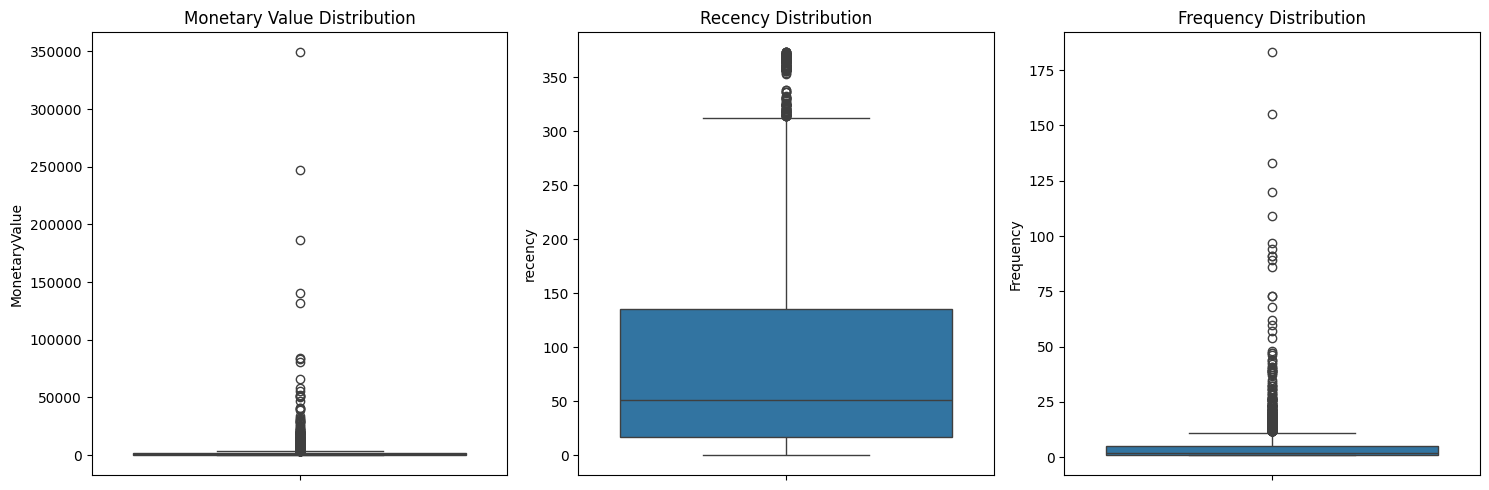

In [41]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot MonetaryValue boxplot
sns.boxplot(y=aggregated_data['MonetaryValue'], ax=axes[0])
axes[0].set_title('Monetary Value Distribution')

# Plot recency boxplot
sns.boxplot(y=aggregated_data['recency'], ax=axes[1])
axes[1].set_title('Recency Distribution')

# Plot Frequency boxplot
sns.boxplot(y=aggregated_data['Frequency'], ax=axes[2])
axes[2].set_title('Frequency Distribution')

plt.tight_layout()
plt.show()


On remarque que:
* MonetaryValue et Frequency: souffrent qd'un probs de outliers
* On va donc redefinir un moyen pour detecter les outliers avec l'intervalle Inter-quartile

In [42]:
#On defini donc les quantiles
M_Q1= aggregated_data['MonetaryValue'].quantile(0.25)
M_Q3= aggregated_data['MonetaryValue'].quantile(0.75)
M_IQR= M_Q3-M_Q1
outliers_M= aggregated_data[(aggregated_data['MonetaryValue']<M_Q1-1.5*M_IQR) | (aggregated_data['MonetaryValue']>M_Q3+1.5*M_IQR)]
outliers_M.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency
count,423.000000,423.000000,423.000000,423,423.000000
mean,15103.040189,12188.101740,17.167849,2010-11-09 12:26:02.978723328,30.035461
min,12357.000000,3802.040000,1.000000,2009-12-10 18:03:00,0.000000
25%,13622.000000,4605.940000,8.000000,2010-11-08 13:17:30,3.000000
50%,14961.000000,6191.320000,12.000000,2010-11-26 12:19:00,13.000000
75%,16692.000000,10273.235000,18.000000,2010-12-06 10:34:30,31.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,364.000000
std,1728.661406,25830.851045,19.729755,NaN,51.541004


Il ya total 423 outliers sur la colonne MonetaryValue

In [43]:
#Calcul sur la colonne Frequency
F_Q1= aggregated_data['Frequency'].quantile(0.25)
F_Q3= aggregated_data['Frequency'].quantile(0.75)
F_IQR= F_Q3-F_Q1
outliers_F= aggregated_data[(aggregated_data['Frequency']<F_Q1-1.5*F_IQR) | (aggregated_data['Frequency']>F_Q3+1.5*F_IQR)]
outliers_F.describe()


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency
count,279.000000,279.000000,279.000000,279,279.000000
mean,15352.655914,14409.714932,23.810036,2010-11-23 11:06:20.645161216,16.089606
min,12437.000000,1094.390000,12.000000,2010-05-12 16:51:00,0.000000
25%,13800.000000,4331.560500,13.000000,2010-11-20 13:14:30,2.000000
50%,15465.000000,6615.770000,17.000000,2010-12-02 10:46:00,7.000000
75%,16828.500000,11692.405000,23.000000,2010-12-07 11:08:30,19.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,211.000000
std,1748.429987,31381.736785,21.932937,NaN,26.589117


* Il ya aussi 279 individus abberents sur la colonnes Frequency

In [95]:
# On prend maintenant les donnes non_aberrentes
non_outliers_data= aggregated_data[(~aggregated_data.index.isin(outliers_M.index)) & (~aggregated_data.index.isin(outliers_F.index))]
non_outliers_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00,17
4281,18284.0,411.68,1,2010-10-04 11:33:00,66
4282,18285.0,377.00,1,2010-02-17 10:24:00,295
4283,18286.0,1246.43,2,2010-08-20 11:57:00,111


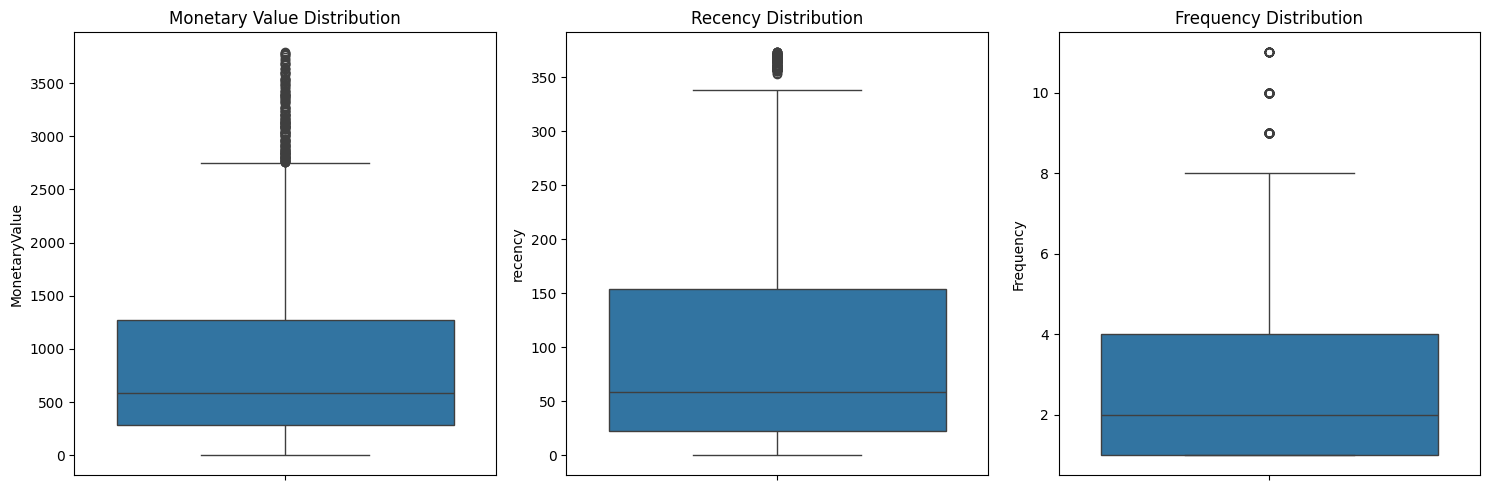

In [45]:
# Create subplots for boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot MonetaryValue boxplot
sns.boxplot(y=non_outliers_data['MonetaryValue'], ax=axes[0])
axes[0].set_title('Monetary Value Distribution')

# Plot recency boxplot
sns.boxplot(y=non_outliers_data['recency'], ax=axes[1])
axes[1].set_title('Recency Distribution')

# Plot Frequency boxplot
sns.boxplot(y=non_outliers_data['Frequency'], ax=axes[2])
axes[2].set_title('Frequency Distribution')

plt.tight_layout()
plt.show()


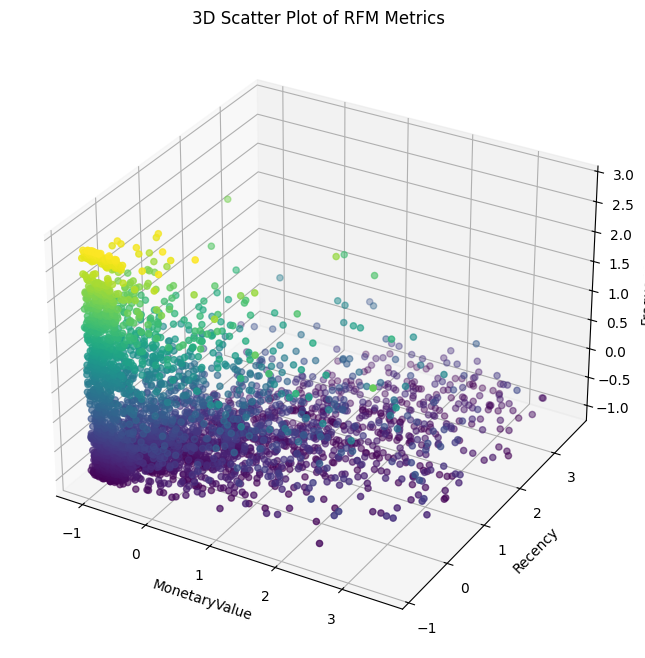

In [94]:
# Assuming 'non_outliers_data' DataFrame is already created

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = non_outliers_data['MonetaryValue']
z = non_outliers_data['recency']
y = non_outliers_data['Frequency']

ax.scatter(x, y, z, c=z, cmap='viridis')  # Use colormap for better visualization

ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('3D Scatter Plot of RFM Metrics')

plt.show()


## La normalisation des données
On va utiliser un StandardScaler pour normaliser nos donnees N(0,1)

In [50]:
scaler = StandardScaler()
non_outliers_data[['MonetaryValue', 'recency', 'Frequency']] = scaler.fit_transform(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])
non_outliers_data

<ipython-input-50-9add7450b2b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_data[['MonetaryValue', 'recency', 'Frequency']] = scaler.fit_transform(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency
0,12346.0,-0.875945,-0.384889,2010-06-28 13:53:00,0.682149
1,12347.0,0.535514,-0.384889,2010-12-07 14:57:00,-0.969251
2,12348.0,-0.812586,-0.830631,2010-09-27 14:59:00,-0.245489
3,12349.0,1.633678,-0.384889,2010-10-28 08:23:00,-0.561498
4,12351.0,-0.715016,-0.830631,2010-11-29 15:23:00,-0.887700
...,...,...,...,...,...
4280,18283.0,-0.298120,1.398076,2010-11-22 15:30:00,-0.816344
4281,18284.0,-0.579553,-0.830631,2010-10-04 11:33:00,-0.316846
4282,18285.0,-0.621972,-0.830631,2010-02-17 10:24:00,2.017539
4283,18286.0,0.441467,-0.384889,2010-08-20 11:57:00,0.141876


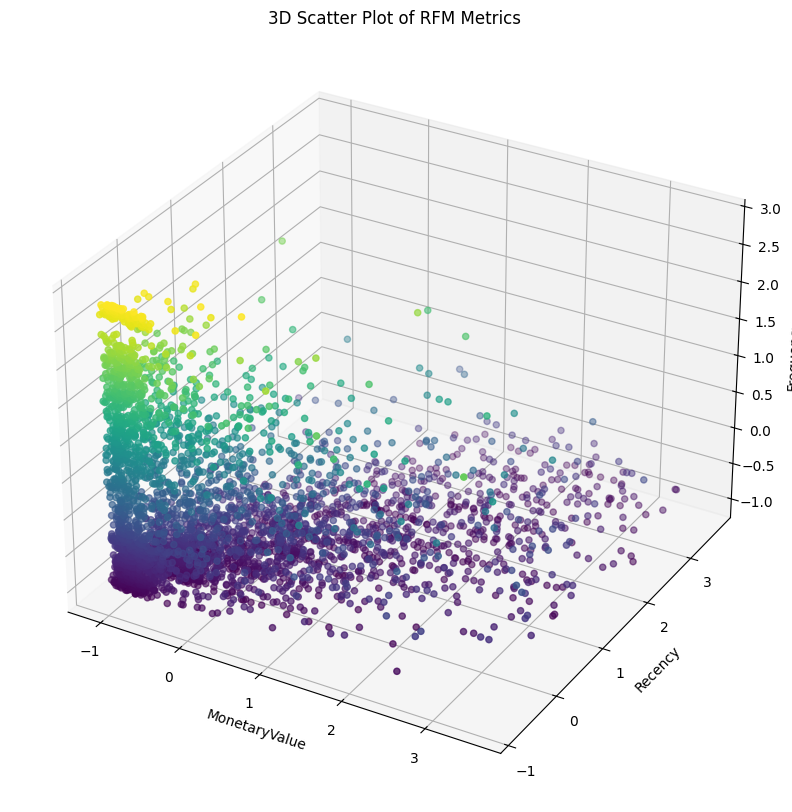

In [93]:
# Assuming 'non_outliers_data' DataFrame is already created

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = non_outliers_data['MonetaryValue']
z = non_outliers_data['recency']
y = non_outliers_data['Frequency']

ax.scatter(x, y, z, c=z, cmap='viridis')  # Use colormap for better visualization

ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('3D Scatter Plot of RFM Metrics')

plt.show()


## KMeans Clustering

### Premiere approche

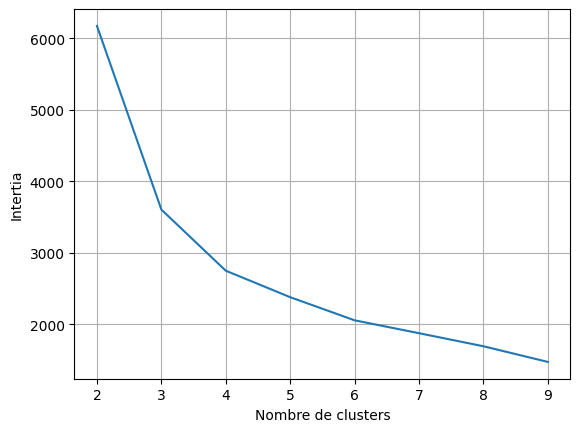

In [64]:
# Determinons le nombre de K optimal
intertia= []
for k in range(2,10):
  model= KMeans(n_clusters=k)
  model.fit(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])
  intertia.append(model.inertia_)
plt.plot(range(2,10), intertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Intertia')
plt.grid()
plt.show()

Nous allons utiliser le silhouette score


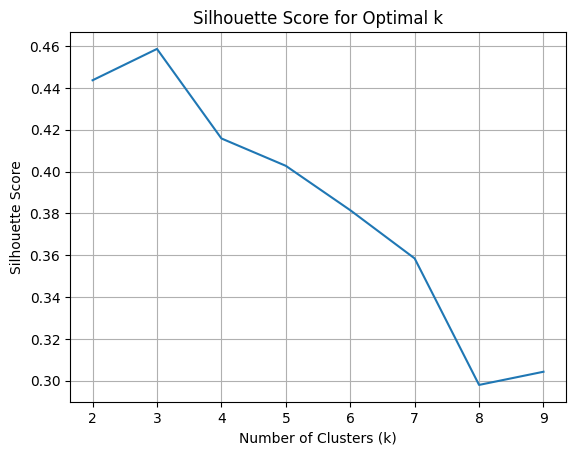

Optimal number of clusters (k) based on Silhouette Score: 3


In [63]:

silhouette_scores = []
for k in range(2, 10):  # Test k from 2 to 9
    kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility
    cluster_labels = kmeans.fit_predict(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])
    silhouette_avg = silhouette_score(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

optimal_k = range(2, 10)[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (k) based on Silhouette Score: {optimal_k}")


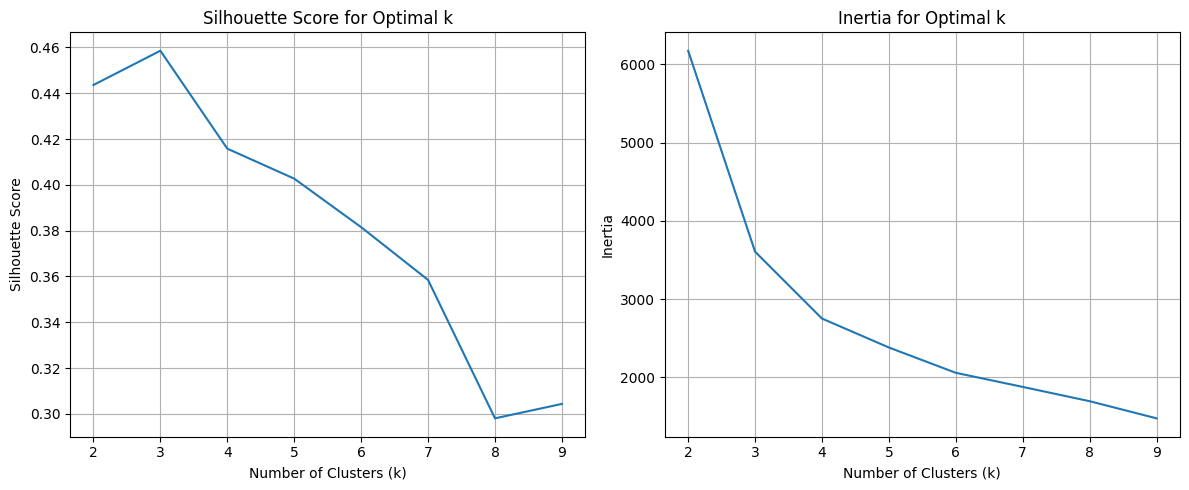

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot silhouette scores
axes[0].plot(range(2, 10), silhouette_scores)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score for Optimal k')
axes[0].grid(True)

# Plot inertia
axes[1].plot(range(2, 10), intertia)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia')
axes[1].set_title('Inertia for Optimal k')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Il est clair que:
* La valeur optimale pour le k=3
* le silhouette score est =~0.46

In [70]:
# Entrainement du model avec k=3
model= KMeans(n_clusters=3)
model.fit(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])

KMeans(n_clusters=3)

In [72]:
cluster_label=model.predict(non_outliers_data[['MonetaryValue', 'recency', 'Frequency']])

In [73]:
# On ajoute cette colonne a notre dataset
non_outliers_data['Cluster']= cluster_label

<ipython-input-73-eea39d41051e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_data['Cluster']= cluster_label


In [74]:
non_outliers_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,recency,Cluster
0,12346.0,-0.875945,-0.384889,2010-06-28 13:53:00,0.682149,1
1,12347.0,0.535514,-0.384889,2010-12-07 14:57:00,-0.969251,0
2,12348.0,-0.812586,-0.830631,2010-09-27 14:59:00,-0.245489,0
3,12349.0,1.633678,-0.384889,2010-10-28 08:23:00,-0.561498,2
4,12351.0,-0.715016,-0.830631,2010-11-29 15:23:00,-0.887700,0
...,...,...,...,...,...,...
4280,18283.0,-0.298120,1.398076,2010-11-22 15:30:00,-0.816344,0
4281,18284.0,-0.579553,-0.830631,2010-10-04 11:33:00,-0.316846,0
4282,18285.0,-0.621972,-0.830631,2010-02-17 10:24:00,2.017539,1
4283,18286.0,0.441467,-0.384889,2010-08-20 11:57:00,0.141876,0


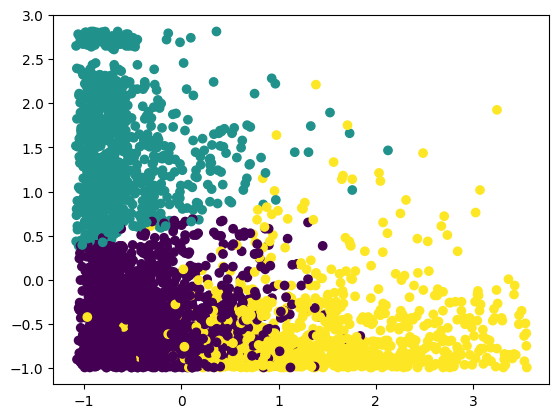

In [76]:
plt.scatter(non_outliers_data['MonetaryValue'], non_outliers_data['recency'], c=non_outliers_data['Cluster'], cmap='viridis');

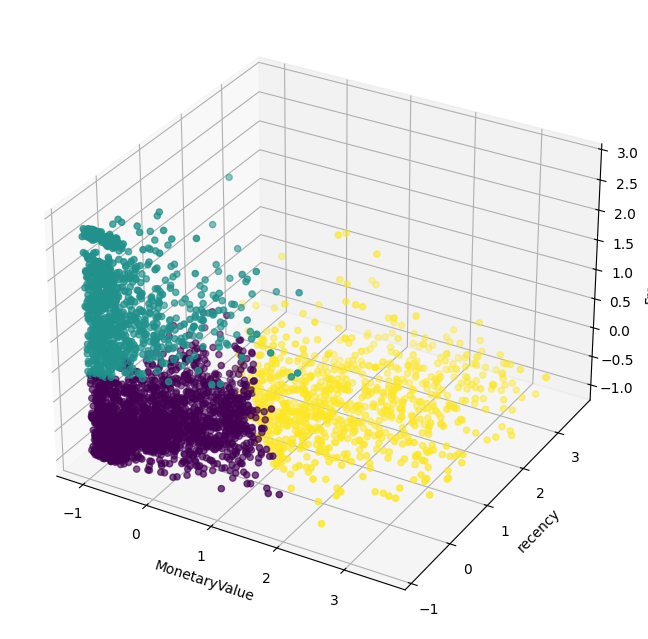

In [92]:
# Affichage en 3D
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
x= non_outliers_data['MonetaryValue']
z= non_outliers_data['recency']
y= non_outliers_data['Frequency']
ax.scatter(x, y, z, c=non_outliers_data['Cluster'], cmap='viridis')
ax.set_xlabel('MonetaryValue')
ax.set_ylabel('recency')
ax.set_zlabel('Frequency')
plt.show()



In [80]:
#Separer les clusters
cluster_0= non_outliers_data[non_outliers_data['Cluster']==0]
cluster_1= non_outliers_data[non_outliers_data['Cluster']==1]
cluster_2= non_outliers_data[non_outliers_data['Cluster']==2]

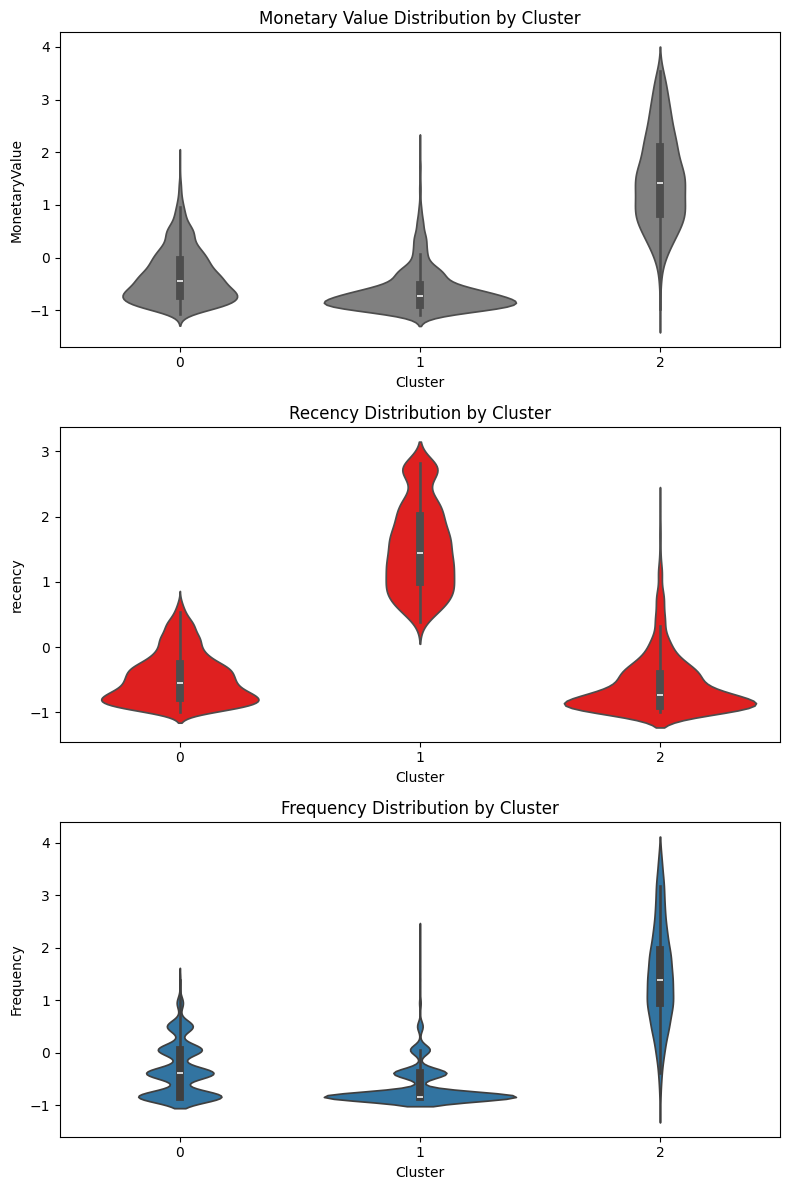

In [91]:
# Creation des subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot MonetaryValue
sns.violinplot(x='Cluster', y='MonetaryValue',color="gray", data=non_outliers_data, ax=axes[0])
axes[0].set_title('Monetary Value Distribution by Cluster')

# Plot recency
sns.violinplot(x='Cluster', y='recency',color="red", data=non_outliers_data, ax=axes[1])
axes[1].set_title('Recency Distribution by Cluster')

# Plot Frequency
sns.violinplot(x='Cluster', y='Frequency', data=non_outliers_data, ax=axes[2])
axes[2].set_title('Frequency Distribution by Cluster')

plt.tight_layout()
plt.show()


### Interprétation des graphiques en violon
Les graphiques en violon visualisent la distribution des valeurs de 'Valeur Monétaire', 'Récence', et 'Fréquence' pour chacun des trois clusters de clients identifiés par l'algorithme KMeans. Voici une interprétation détaillée :
#### Valeur Monétaire :
* Cluster 0 : Présente une médiane de 'Valeur Monétaire' plus faible par rapport aux deux autres clusters et une distribution plus resserrée. Ce cluster représente probablement des clients qui dépensent moins en moyenne.
* Cluster 1 : Montre une distribution plus large avec une médiane de 'Valeur Monétaire' plus élevée que le Cluster 0. Cela suggère que les clients de ce cluster ont des habitudes de dépenses variées, mais tendent à dépenser plus.
* Cluster 2 : A la médiane de 'Valeur Monétaire' la plus élevée et une distribution modérément large. Ce cluster représente probablement les clients les plus précieux, ceux qui dépensent le plus.
#### Récence :
* Cluster 0 : La distribution suggère un mélange d'achats récents et moins récents, avec certains clients ayant une valeur de récence plus élevée que d'autres. Des achats plus récents sont probablement indiqués par des valeurs plus faibles ici.
* Cluster 1 : Ce cluster semble être caractérisé par des achats plus récents, car la distribution est concentrée vers les valeurs de récence plus faibles (c'est-à-dire qu'ils ont acheté plus récemment).
* Cluster 2 : Une distribution plus large, avec une médiane de récence légèrement plus élevée que le Cluster 1. Certains clients de ce groupe ont peut-être fait des achats récemment, mais il inclut également des clients qui n'ont pas acheté depuis un certain temps.
#### Fréquence :
* Cluster 0 : Une fréquence d'achat plus faible par rapport aux autres clusters. Ce sont probablement des clients qui n'achètent pas très souvent.
* Cluster 1 : La médiane de fréquence semble plus élevée que celle du Cluster 0. Ces clients achètent probablement plus fréquemment.
* Cluster 2 : Une médiane de fréquence élevée avec une distribution large, indiquant que ce groupe comprend des acheteurs très fréquents et peut-être des clients moins fréquents mais toujours précieux.
#### Interprétation globale et implications commerciales :
* Cluster 0 : Ce sont probablement vos clients les moins précieux, qui dépensent moins, n'achètent pas souvent, et dont la récence d'achat varie. Les stratégies pour ce cluster pourraient inclure des incitations à des achats répétés ou des promotions ciblées pour augmenter leurs dépenses et leur fréquence d'achat.
* Cluster 1 : Ce cluster semble être votre groupe principal de clients, avec des dépenses modérées, une bonne fréquence d'achat et une activité récente. L'accent pourrait être mis sur le maintien de leur fidélité grâce à des programmes de fidélité ou des offres exclusives.
* Cluster 2 : Ce segment représente vos clients à haute valeur, avec des dépenses et une fréquence d'achat élevées, bien que leur récence soit légèrement variable. La rétention est cruciale pour ce cluster, donc offrir des recommandations personnalisées ou des services premium pourrait être bénéfique. Il est également important de réfléchir à la manière de ramener ceux dont la récence est plus élevée à des achats répétés.